In [24]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

import seaborn as sns
sns.set_style('whitegrid')


In [25]:
# ----------------------- Data loading and preprocessig ---------------------- #

file_train = 'ZipDigits.train'
file_test = 'ZipDigits.test'


def read_data(file_name):
    digits = []
    images = []
    with open(file_name, 'r') as f:
        for line in f:
            line = line.strip().split(' ')
            line = [float(i) for i in line]
            digit = int(line[0])
            data = line[1:]
            images.append(data)
            digits.append(digit)
    return np.array(images), np.array(digits)


def get_features(file_name):
    images, digits = read_data(file_name)
    images = images.reshape(-1, 16, 16)
    images = (images + 1) / 2  # normalize between [0,1]

    index = (digits == 1) | (digits == 5)
    images = images[index]
    digits = digits[index]

    # Extract feature
    intensities = images.reshape(-1, 16 * 16).mean(axis=-1)
    symmetry = np.power(images[..., ::-1] - images,
                        2).reshape(images.shape[0], -1).mean(axis=-1)

    ind_1 = (digits == 1)
    ind_5 = (digits == 5)
    labels = np.zeros(digits.shape[0])
    labels[ind_1] = 1
    labels[ind_5] = -1
    features = np.concatenate((intensities[:, None], symmetry[:, None]),
                              axis=1)
    return features, labels


# ------------------------------ train features ------------------------------ #
features_train, labels_train = get_features(file_train)

# ------------------------------- test features ------------------------------ #
features_test, labels_test = get_features(file_test)

# ----------------------------- combine the data ----------------------------- #
features = np.concatenate((features_train, features_test), axis=0)
labels = np.concatenate((labels_train, labels_test), axis=0)

In [26]:
# normalize features
import sklearn.preprocessing as preprocessing

features = preprocessing.MinMaxScaler(
    feature_range=(-1, 1)).fit_transform(features)

# split test and train
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, train_size=300, random_state=42)

In [27]:
class KNNClassifier(object):
    def __init__(self, X, Y):
        self.X = X  # shape: (n, d)
        self.Y = Y  # shape: (n,)

    def predict(self, x, K=1):
        k, d = x.shape
        n, d = self.X.shape
        x = x.reshape(k, 1, d)
        Data = self.X.reshape(1, n, d)
        distance_scale = self.distance(x, Data, k=K)  # shape: (k, n)

        # print(distance_scale.shape, self.Y.shape)
        pred = (np.sum(distance_scale * self.Y[None, :], axis=-1) / np.sum(distance_scale, axis=1))

        return np.sign(pred)

    def distance(self, x, y, k=1):
        scale = 2 / np.sqrt(k)
        e_dist = np.linalg.norm(x - y, axis=-1)
        return self.rbf(e_dist / scale)

    def rbf(self, z):
        return np.exp(-0.5 * z**2)


# 1

## (a)
Use cross validation with your training set to select 
the optimal value of k for the k-NN rule


In [28]:

dict_info = {}
for k in tqdm(range(1, 50)):
    e_cv = []
    for i in range(len(features_train)):
        X_train, y_train = np.delete(features_train, i, axis=0), np.delete(labels_train, i)
        X_val, y_val = features_train[[i]], labels_train[[i]]
        knnClf = KNNClassifier(X_train, y_train)
        pred = knnClf.predict(X_val, K=k)
        acc_score = np.mean(pred == y_val)
        e_cv.append(1 - acc_score)
    avg_e_cv = np.mean(e_cv)
    dict_info[k] = avg_e_cv

ind_opt = np.argmin(list(dict_info.values()))
opt_k = list(dict_info.keys())[ind_opt]
print('optimum error: ', dict_info[opt_k])
print('optimal k:', opt_k)


100%|██████████| 49/49 [00:01<00:00, 44.91it/s]

optimum error:  0.03666666666666667
optimal k: 32


In [29]:
pred_train = knnClf.predict(features_train, K=opt_k)
acc_score = np.mean(pred_train == labels_train)
E_in = 1 - acc_score
print('E_in:', E_in)

E_in: 0.036666666666666625


Text(0, 0.5, 'E_cv')

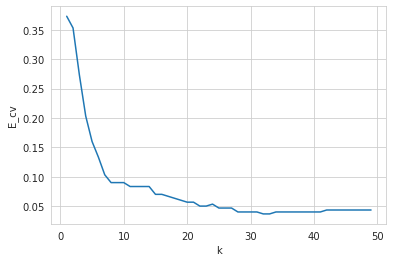

In [30]:
plt.plot(list(dict_info.keys()), list(dict_info.values()))
plt.xlabel('k')
plt.ylabel('E_cv')

# (b)
Plot of the decision boundary

In [31]:
from matplotlib.colors import ListedColormap


In [32]:
knnClf = KNNClassifier(features_train, labels_train)

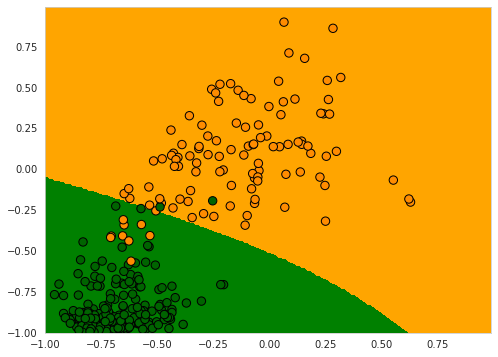

In [33]:
cmap_light = ListedColormap(["orange", "green"])
cmap_dark = ListedColormap(["darkorange", "darkgreen"])

xx, yy = np.meshgrid(np.arange(-1, 1, 0.01), np.arange(-1, 1, 0.01))
Z = knnClf.predict(np.c_[xx.ravel(), yy.ravel()], K=opt_k)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap=cmap_light)
plt.scatter(features_train[:, 0], features_train[:, 1], c=labels_train, s=70, cmap=cmap_dark, edgecolors="black")


# (c)

What is the test error E_test?

In [34]:
pred_test = knnClf.predict(features_test, K=opt_k)
acc_score = np.mean(pred_test == labels_test)
E_test = 1 - acc_score
print('E_test:', E_test)

E_test: 0.03620178041543032
